In [2]:
# 1. Import Libraries
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [4]:
# 2. Load Data
with open('../data/user-wallet-transactions.json') as f:
    data = json.load(f)

df = pd.json_normalize(data)
df.head()

,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,_id.$oid,...,actionData.repayerId,actionData.liquidatorId,actionData.collateralAmount,actionData.collateralAssetPriceUSD,actionData.principalAmount,actionData.borrowAssetPriceUSD,actionData.collateralReserveId,actionData.collateralReserveSymbol,actionData.principalReserveId,actionData.principalReserveSymbol
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,0,681d38fed63812d4655f571a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,0,681aa70dd6df53021cc6f3c0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,0,681d04c2d63812d4654c733e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,0,681d133bd63812d46551b6ef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,0,681899e4ba49fc91cf2f4454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 3. Feature Engineering

def engineer_features(df):
    """
    Engineers features from raw transaction data per wallet.
    """

    # Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

    # Convert amount to numeric USD value
    df['amount_usd'] = pd.to_numeric(df['actionData.amount'], errors='coerce') * pd.to_numeric(df['actionData.assetPriceUSD'], errors='coerce')

    # Group by wallet and engineer features
    grouped = df.groupby('userWallet').agg(
        total_deposits_usd = pd.NamedAgg(column='amount_usd', aggfunc=lambda x: x[df['action']=='deposit'].sum()),
        total_redeems_usd = pd.NamedAgg(column='amount_usd', aggfunc=lambda x: x[df['action']=='redeemunderlying'].sum()),
        txn_count = pd.NamedAgg(column='action', aggfunc='count'),
        unique_assets = pd.NamedAgg(column='actionData.assetSymbol', aggfunc=pd.Series.nunique),
        max_deposit_usd = pd.NamedAgg(column='amount_usd', aggfunc=lambda x: x[df['action']=='deposit'].max()),
        has_liquidation = pd.NamedAgg(column='action', aggfunc=lambda x: int('liquidationcall' in x.values)),
        avg_deposit_usd = pd.NamedAgg(column='amount_usd', aggfunc=lambda x: x[df['action']=='deposit'].mean()),
    ).reset_index()

    grouped.fillna(0, inplace=True)

    return grouped

features_df = engineer_features(df)

print("Feature engineering complete. Features shape:", features_df.shape)
features_df.head()

✅ Feature engineering complete. Features shape: (3497, 8)


,userWallet,total_deposits_usd,total_redeems_usd,txn_count,unique_assets,max_deposit_usd,has_liquidation,avg_deposit_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1.987664e+09,0.000000e+00,1,1,1.987664e+09,0,1.987664e+09
1,0x000000000051d07a4fb3bd10121a343d85818da6,2.856945e+20,0.000000e+00,1,1,2.856945e+20,0,2.856945e+20
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.152311e+15,0.000000e+00,2,1,4.229933e+15,0,2.576155e+15
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,9.803600e+20,17,4,0.000000e+00,0,0.000000e+00
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2.065773e+23,1.128745e+23,399,6,2.674171e+22,0,8.263093e+20


In [8]:
def generate_scores(df):
    """
    Generates a scaled score between 0-1000 for each wallet based on engineered features.
    """

    scaler = MinMaxScaler(feature_range=(0,1000))
    score_cols = ['total_deposits_usd', 'total_redeems_usd', 'txn_count', 'unique_assets', 'max_deposit_usd']

    df[score_cols] = scaler.fit_transform(df[score_cols])

    df['score'] = df[score_cols].mean(axis=1)
    df['score'] = (df['score'] / df['score'].max()) * 1000
    df['score'] = df['score'].round(0)

    return df[['userWallet','score']]

In [10]:
scores_df = generate_scores(features_df)

count    3497.000000
mean       60.311982
std        84.610970
min         0.000000
25%         0.000000
50%        40.000000
75%        81.000000
max      1000.000000
Name: score, dtype: float64


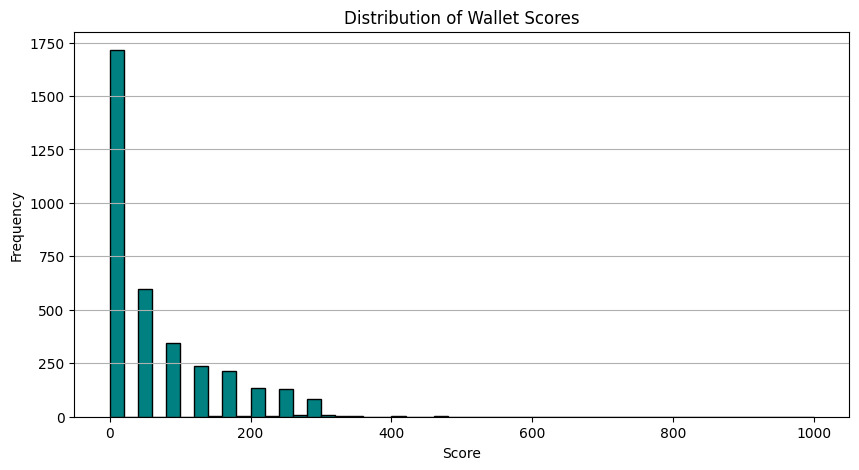

In [11]:
# 6. Statistical Analysis

print(scores_df['score'].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(scores_df['score'], bins=50, color='teal', edgecolor='black')
plt.title('Distribution of Wallet Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
